<a href="https://colab.research.google.com/github/maximepeg/BDF_notebooks/blob/main/BDF_11_Graph_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#00 - Configuration of Apache Spark on Collaboratory


###Installing Java, Spark, and Findspark


---


This code installs Apache Spark 3.0.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop2.7.tgz   
!tar xf spark-3.2.2-bin-hadoop2.7.tgz  
!rm spark-3.2.2-bin-hadoop2.7.tgz    
!pip install -q findspark

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.co

In [ ]:
#!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

--2022-11-23 08:41:41--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 108.157.162.51, 108.157.162.52, 108.157.162.5, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|108.157.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.06s   

2022-11-23 08:41:41 (3.99 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar’ saved [247880/247880]



### Set Environment Variables
Set the locations where Spark and Java are installed.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Enseignement/2022-2023/ING3/HPDA/BigDataFrameworks/data/"

!rm /content/spark
!ln -s /content/spark-3.2.2-bin-hadoop2.7 /content/spark

#!mv graphframes-0.8.1-spark3.0-s_2.12.jar /content/spark/jars/
!mv graphframes-0.8.2-spark3.2-s_2.12.jar /content/spark/jars/

!export SPARK_HOME=/content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin

!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

!ls -l /content/

rm: cannot remove '/content/spark': No such file or directory
/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/Enseignement/2022-2023/ING3/HPDA/BigDataFrameworks/data/
total 8
drwxr-xr-x  1 root root 4096 Nov 22 00:14 sample_data
lrwxrwxrwx  1 root root   34 Nov 23 08:45 spark -> /content/spark-3.2.2-bin-hadoop2.7
drwxr-xr-x 13 1000 1000 4096 Jul 11 16:16 spark-3.2.2-bin-hadoop2.7


### Start a SparkSession
This will start a local Spark session.

In [ ]:
!python -V
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

sc.addPyFile('/content/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

# Example: shows the PySpark version
print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.7.15
PySpark version 3.2.2


[2, 3]

In [ ]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("packages","graphframes:graphframes-0.8.1-spark3.0-s_2.12") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



---


# 11 - Graph processing

## GraphX: Graph processing with RDDs

Parallel graph programming using Spark

- Main abstraction: [*Graph*](http://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.graphx.Graph)
    -   Directed multigraph with properties assigned to vertices and edges 
    -   It is an extension of the RDDs
- It includes graph constructors, basic operators ( *reverse*, *subgraph*…) and graph algorithms ( *PageRank*, *Triangle Counting*…)
- Only availabe on Scala.

Documentation: [spark.apache.org/docs/latest/graphx-programming-guide.html](http://spark.apache.org/docs/latest/graphx-programming-guide.html)

API: https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.graphx.package

## Graphs in GraphX
<img src="http://persoal.citius.usc.es/tf.pena/TCDM/figs/grapxgraph.png" alt="Grafo en GraphX" style="width: 50px;"/>
(Source: M.S. Malak, R. East "Spark GraphX in action", Manning, 2016)

### Example of a simple graph
<img src="http://persoal.citius.usc.es/tf.pena/TCDM/figs/simpsonsgraph.png" alt="Grafo de los Simpson" style="width: 600px;"/>
(Source: P. Zecević, M. Bonaći "Spark in action", Manning, 2017)

## GraphFrames: : Graph processing with DataFrames

In Python we can use [*GraphFrames*](https://graphframes.github.io/graphframes/docs/_site/quick-start.html) which wraps GraphX algorithms under the DataFrames API, providing a Python interface.

- Support for multiple languages is on the works
    - For now,  available for Scala and Python 
- Not yet integrated on Spark
    - Available as an external package (https://spark-packages.org/package/graphframes/graphframes)

More information:
- Project web: https://graphframes.github.io/graphframes/docs/_site/
- Python API : https://graphframes.github.io/graphframes/docs/_site/api/python/index.html


### Graphs using pyspark and GraphFrames

In [ ]:
# The following example shows how to create a GraphFrame, query it, and run the PageRank algorithm.
# Source: https://graphframes.github.io/graphframes/docs/_site/quick-start.html

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from graphframes import *

# Create a Vertex DataFrame with unique ID column "id"
v = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame

g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()

/content/spark/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       1|
+---+--------+

+---+------------------+
| id|          pagerank|
+---+------------------+
|  c|1.8994109890559092|
|  b|1.0905890109440908|
|  a|              0.01|
+---+------------------+



In [ ]:
e.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
+---+---+------------+



#Exercises

## Exercise 11.1:

A long time ago in a galaxy far, far away, the characters of the Star Wars franchise interacted with each other in an endless series of films. An ancient Jedi order, called the *Data Guardians of the Galaxy* (not affiliated to Marvel's homonym :) registered all those interactions and saved them on a digital file so that they could be studied by the forthcoming generations. This file was originally called (guess it) `sw.txt`, and you will find it in the `/data` directory. 

Using pySpark, perform the following operations and answer the following questions:

1. Load the `$DRIVE_DATA/sw.txt` file. Take into account that it is a JSON file.
2. Using this information, create a graph of interactions between the Star Wars characters.
3. How many different characters are there?
4. How many interactions are there?
5. Who is the central character in Star Wars (the one who interacts in most scenes)? 
6. Who is the character with the highest 'rank' in Star Wars (use the PageRank algorithm)?

In [ ]:
import json
with open(f'{os.environ["DRIVE_DATA"]}sw.txt') as file:
  dic = json.load(file)
dic.keys()

dict_keys(['nodes', 'links'])

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

vertex = spark.createDataFrame(dic["nodes"])
edge = spark.createDataFrame(dic["links"])
vertex = vertex.withColumn("id", monotonically_increasing_id())
edge = edge.withColumnRenamed("target", "dst").withColumnRenamed("source", "src")

In [ ]:
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx
def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    #plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')



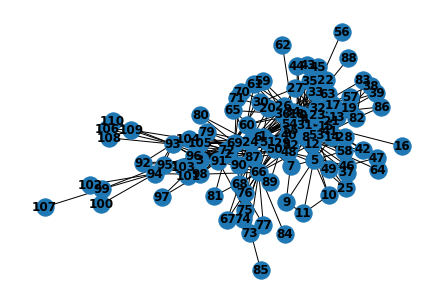

In [ ]:
graph = GraphFrame(vertex, edge)
PlotGraph(graph.edges)

In [ ]:
print(f"There are {graph.vertices.count()} characters in this graph, and {graph.edges.count()} interactions")

There are 111 characters in this graph, and 444 interactions


In [ ]:
a = edge.groupBy("dst").count().orderBy("count", ascending=False).withColumnRenamed("count", "acount")
b = edge.groupBy("src").count().orderBy("count", ascending=False).withColumnRenamed("count", "bcount")

c = a.join(b, a.dst == b.src, "inner")
d = c.withColumn("sum", c.acount+c.bcount).orderBy("sum",ascending=False)
most_interaction = d.collect()[0][0], d.collect()[0][-1]
most_interacted = a.collect()[0][0], a.collect()[0][1]
most_interacting = b.collect()[0][0], b.collect()[0][1]



In [ ]:
def to_name(id):
  return vertex.filter(vertex.id == id).collect()[0][1]

In [ ]:
print(f"The character that is the source of most interaction is {to_name(most_interacting[0])}, with {most_interacting[1]} count of being the source of an interaction")
print(f"The character that is the target of most interaction is {to_name(most_interacted[0])}, with {most_interacted[1]} count of being the target of an interaction")
print(f"The character that participates in the most interaction is {to_name(most_interaction[0])}, with {most_interaction[1]} count of participating in an interaction")


The character that is the source of most interaction is DARTH VADER, with 39 count of being the source of an interaction
The character that is the target of most interaction is PADME, with 23 count of being the target of an interaction
The character that participates in the most interaction is DARTH VADER, with 52 count of participating in an interaction


In [ ]:
result_sw = graph.pageRank(resetProbability=0.01, maxIter=20)


In [ ]:
ranks = result_sw.vertices.orderBy("pagerank", ascending=False)
high_rank = ranks.collect()[0][1]
ranks.show()

+-------+---------------+-----+---+------------------+
| colour|           name|value| id|          pagerank|
+-------+---------------+-----+---+------------------+
|#9ACD32|           YODA|   46| 34| 7.816793973543788|
|#DDA0DD|          PADME|   75| 18| 5.766163683097597|
|#bde0f6|          R2-D2|  171|  1| 4.186811320959878|
|#808080|          WATTO|    9| 20|3.5496485400514874|
|#808080|           SHMI|   12| 23|3.4896346673737733|
|#48D1CC|        OBI-WAN|  148|  8| 3.164444977686932|
|#808080|        SUN RIT|    4| 54|2.9670283784833096|
|#4f4fb1|        QUI-GON|   62|  4| 2.828540834595268|
|#808080|           SOLA|    4| 43| 2.474506591899894|
|#808080|          TC-14|    5|  7|1.9934056249208498|
|#808080|     SIO BIBBLE|    9| 14| 1.924083748712242|
|#000000|    DARTH VADER|  190|  0|1.8638155208749687|
|#808080|SENATOR ASK AAK|    4| 41| 1.704242800429791|
|#808080|       RIC OLIE|   12| 19|1.6742378318825124|
|#808080|        TEY HOW|    5| 11| 1.665410435325444|
|#808080| 

In [ ]:
print(f"The character with the highest pagerank is  {high_rank}")

The character with the highest pagerank is  YODA
